# Set up the environment

In [3]:
#Arguments/Parameters

working_dir = '/home/jupyter/notebooks/Ancestry' #home directory for this workspace
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET') #the workspace bucket that we will upload the output to
num.threads = 8 #Specify the number of CPUs you want to use. Some steps take a lot of compute.

In [4]:
#Load packages
library(tidyverse)
library(genefu)
library(qqman)
library(ggtext)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

In [4]:
system(glue::glue("
if [ ! -d '{working_dir}/gwas' ] 
then
mkdir {working_dir}/gwas
fi

if [ ! -d '{working_dir}/gwas/gwas_output' ] 
then
mkdir {working_dir}/gwas/gwas_output
fi

"))

In [ ]:
#Download and install bcftools
#Install bcftools
step_install_bcftools <- !file.exists(glue::glue("{working_dir}/software/bcftools/bcftools"))

if(step_install_bcftools) {
system(glue::glue("
cd {working_dir}/software
git clone --recurse-submodules git://github.com/samtools/htslib.git
git clone git://github.com/samtools/bcftools.git
cd bcftools
autoheader && autoconf && ./configure --enable-libgsl --enable-perl-filters
make
export BCFTOOLS_PLUGINS=/home/jupyter-user/notebooks/Ancestry/software/bcftools/plugins
")) } else {print("bcftools is already installed")}

In [ ]:
#Install tabix

In [ ]:
#Download and unpack PLINK

system(glue::glue("
mkdir {working_dir}/software/plink2
cd {working_dir}/software/plink2
wget https://s3.amazonaws.com/plink2-assets/plink2_linux_avx2_20210826.zip
unzip plink2_linux_avx2_20210826.zip
"))


system(glue::glue("
mkdir {working_dir}/software/plink
cd {working_dir}/software/plink
wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip
unzip plink_linux_x86_64_20210606.zip
"))

# Format the data in the PLINK format

In [4]:
#Convert the data into the PLINK format
system(glue::glue("
cd {working_dir}/gwas
{working_dir}/software/plink2/plink2 --allow-extra-chr --vcf {working_dir}/gwas/intronexon.ccle.vcf.gz --make-bed --out intronexon.ccle
"))

# Generate covariate file

Run PCA for the covariate file

In [5]:
#Run PCA
system(glue::glue("
cd {working_dir}/gwas
{working_dir}/software/plink2/plink2 --allow-extra-chr --bfile intronexon.ccle --pca 10 --maf 0.01 --out intronexon.ccle.pca10
"))

In [6]:
#Format the cell covariates

#Download the DepMap sample annotation file 
system(glue::glue("
cd {working_dir}/gwas
gsutil cp {workspace_bucket}/internal-21q3_v15-sample-info.csv .
"))

#Load in the sample annotation file
paste(working_dir, "/gwas", sep = "") %>% setwd()
cell.annotation <- read.table('internal-21q3_v15-sample-info.csv', sep = ",", fill = TRUE, header = TRUE) #Load in the sample header that contains all of the samples in the vcf file

#Format the covariates file
covariates <- cbind(cell.annotation$DepMap_ID, cell.annotation$lineage) %>% data.frame
colnames(covariates) <- c("ach_id", "lineage")


write.table(covariates, "cell.covariates.txt", sep = "\t", col.names = T, row.names = F, quote = F)

In [7]:
#Load in both of the covariate files and then merge them together into a single .cov file that is in the correct format
paste(working_dir, "/gwas", sep = "") %>% setwd() #set the working directory
pca.cov <- read.table('intronexon.ccle.pca10.eigenvec', sep = "\t", fill = TRUE) #Covariates from PCA
pca.cov <- pca.cov[,-1] #Remove the first column from pca.cov since we don't care about it
lineage.cov <- read.table('cell.covariates.txt', sep = "\t", fill = TRUE, header = TRUE) #Covariates from annotation file


#Assign the column names to pca.cov
colnames(pca.cov) <- c("ach_id", "pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10")

#Convert the tumor types into numbers so that we can add it to the covariates file
unique.lineage <- lineage.cov$lineage %>% unique()
lineage.numbers <- seq(from = 1, to = length(unique.lineage), by = 1)
lineage.encoding <- cbind(unique.lineage, lineage.numbers) %>% data.frame()
colnames(lineage.encoding) <- c("lineage", "number")
lineage.cov$lineage <- plyr::mapvalues(lineage.cov$lineage, from = lineage.encoding$lineage, to = lineage.encoding$number)



#merge the two datasets together
pca.lineage.cov <- merge(pca.cov, lineage.cov, by = "ach_id")


#format the .cov file
covariate.file <- pca.lineage.cov
colnames(covariate.file)[1] <- c("IID")


#write the covariate file
write.table(covariate.file, "depmap.cov", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

# Generate phenotype files

In [10]:
#Load in the ancestry-associated genes
paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd() #set the working directory
ancestry.associated.genes = read.table("ancestry.associated.genes.txt", sep = "\t") %>%
pull(1)

head(ancestry.associated.genes)

[1] "CLSPN"   "RHOB"    "RHD"     "UGT2B17" "CHGB"    "C7orf25"

In [11]:
#Format the phenotype file

#Download the depmap chronos scores
system(glue::glue("
cd {working_dir}/gwas
gsutil cp {workspace_bucket}/CRISPR_gene_effect.csv .
"))

#Load the chronos scores and format it
paste(working_dir, "/gwas", sep = "") %>% setwd() #set the working directory
chronos.scores <- read.table('CRISPR_gene_effect.csv', sep = ",", header = F)
colnames(chronos.scores) = sub(" .*", "", chronos.scores[1,]) #Remove all of the junk after the gene name
chronos.scores <- chronos.scores[-1,] #Remove the old 'col.names' row.
colnames(chronos.scores)[1] <- "IID" #Convert the column name for the first column to IID, as per the formatting requirements for the .pheno file
chronos.scores[chronos.scores == ""] <- 0 #Replace the missing values with 0. Clearly not the best solution, but it is A solution. And these are rare cases, so it shouldn't affect it too much.   


#Now filter it so that it only includes the ancestry-associated genes 
genes.to.keep = intersect(colnames(chronos.scores), ancestry.associated.genes)
chronos.scores = chronos.scores %>%
dplyr::select(IID, all_of(genes.to.keep), "BRAF", "KRAS", "NRAS", "RAN")


#write the phenotype.file
write.table(chronos.scores, "chronos_gwas_phenotypes.pheno", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

# Run GWAS!!!

In [12]:
#Run GWAS!!!
system(glue::glue("
cd {working_dir}/gwas
{working_dir}/software/plink2/plink2 --allow-extra-chr --bfile intronexon.ccle --maf 0.01 --glm hide-covar --pfilter 1 --covar 'iid-only' depmap.cov --pheno chronos_gwas_phenotypes.pheno --out {working_dir}/gwas/gwas_output/gwas_out
"))

,chr,pos,pval,pos_add,pos_cum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,69270,0.397811,0,69270
2,1,69428,0.346387,0,69428
3,1,69511,0.808022,0,69511
4,1,69761,0.548768,0,69761
5,1,69897,0.543772,0,69897
6,1,926250,0.710917,0,926250


,chr,pos,pval,pos_add,pos_cum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2683295,22,50782762,0.239320,2818891808,2869674570
2683296,22,50783303,0.170454,2818891808,2869675111
2683297,22,50783320,0.432770,2818891808,2869675128
2683298,22,50783547,0.471936,2818891808,2869675355
2683299,22,50783624,0.298407,2818891808,2869675432
2683300,22,50783643,0.952199,2818891808,2869675451


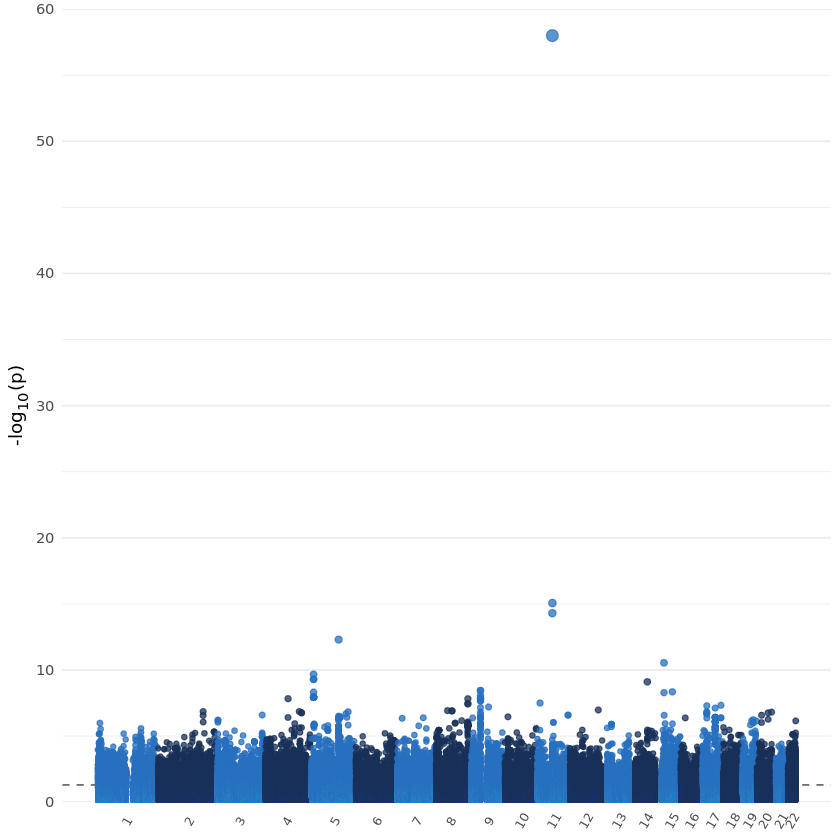

In [15]:
###GWAS seemed to work. Next step, make a manhattanplot
###Crap code, fix later

chromosomes = c(seq(from = 1, to = 22, by = 1), "X")

setwd('/home/jupyter/notebooks/Ancestry/gwas/gwas_output')
gwas.data = read.table('gwas_out.TUT1.glm.linear', sep = "\t", header = F) %>%
rename("chr" = 1, "pos" = 2, "pval" = 12) %>%
dplyr::select(chr, pos, pval) %>%
filter(chr %in% chromosomes) %>%
mutate(chr = gsub("X", 23, chr)) %>%
mutate_all(function(x) as.numeric(as.character(x)))
           
       
data_cum <- gwas.data %>% 
  group_by(chr) %>% 
  summarise(max_pos = max(pos)) %>% 
  mutate(pos_add = lag(cumsum(max_pos), default = 0)) %>% 
  dplyr::select(chr, pos_add)

gwas.data <- gwas.data %>% 
  inner_join(data_cum, by = "chr") %>% 
  mutate(pos_cum = pos + pos_add)  
           
           
head(gwas.data)
tail(gwas.data)
           
           
axis_set <- gwas.data %>% 
group_by(chr) %>% 
summarize(center = mean(pos_cum))

ylim <- gwas.data %>% 
filter(pval == min(pval)) %>% 
mutate(ylim = abs(floor(log10(pval))) + 2) %>% 
pull(ylim)            
           
           
           
           
gwas.data %>%           
ggplot(aes(x = pos_cum, y = -log10(pval), 
                                  color = as_factor(chr), size = -log10(pval))) +
  geom_hline(yintercept = -log10(0.05), color = "grey40", linetype = "dashed") + 
  geom_point(alpha = 0.75) +
  scale_x_continuous(label = axis_set$chr, breaks = axis_set$center) +
  scale_y_continuous(expand = c(0,0), limits = c(0, ylim)) +
  scale_color_manual(values = rep(c("#276FBF", "#183059"), unique(length(axis_set$chr)))) +
  scale_size_continuous(range = c(0.5,3)) +
  labs(x = NULL, 
       y = "-log<sub>10</sub>(p)") + 
  theme_minimal() +
  theme( 
    legend.position = "none",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.title.y = element_markdown(),
    axis.text.x = element_text(angle = 60, size = 8, vjust = 0.5)
  )